In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Load dataset yang akan digunakan
df = pd.read_csv('customer_feedback_satisfaction.csv')

In [212]:
# Fitur yang akan dipakai
features = ['ProductQuality', 'ServiceQuality', 'FeedbackScore']
target = 'SatisfactionScore'

In [213]:
# Kategorikan SatisfactionScore menjadi Low, Medium, High
def categorize_satisfaction(score):
    if score <= 40:
        return 'Low'
    elif score <= 70:
        return 'Medium'
    else:
        return 'High'

In [214]:
# Memasukkan Kategorisasi SatisfactionScore ke data frame (df)
df['Satisfaction_cat'] = df[target].apply(categorize_satisfaction)

In [215]:
# Bagi data menjadi fitur dan target
X = df[features]
y = df['Satisfaction_cat']

# Pembagian data untuk menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [216]:
# Fungsi keanggotaan triangle
def triangular_mf(x, params):
    a, b, c = params
    if x <= a or x >= c:
        return 0.0
    elif a < x <= b:
        return (x - a) / (b - a)
    else:
        return (c - x) / (c - b)

In [217]:
# Fungsi fuzzifikasi untuk ProductQuality (pq = ProductQuality)
def fuzzify_pq(value):
    poor = triangular_mf(value, [1, 1, 5])
    average = triangular_mf(value, [3, 5, 7])
    good = triangular_mf(value, [5, 10, 10])
    return {'Poor': poor, 'Average': average, 'Good': good}

# Fungsi fuzzifikasi untuk ServiceQuality (sq = ServiceQuality)
def fuzzify_sq(value):
    poor = triangular_mf(value, [1, 1, 5])
    average = triangular_mf(value, [3, 5, 7])
    good = triangular_mf(value, [5, 10, 10])
    return {'Poor': poor, 'Average': average, 'Good': good}

# Fuzzifikasi untuk FeedbackScore
def fuzzify_fs(value):
    if value == 'Low':
        return {'Low': 1.0, 'Medium': 0.0, 'High': 0.0}
    elif value == 'Medium':
        return {'Low': 0.0, 'Medium': 1.0, 'High': 0.0}
    elif value == 'High':
        return {'Low': 0.0, 'Medium': 0.0, 'High': 1.0}

In [218]:
# Pendefinisian aturan fuzzy Mamdani
rules = [
    # ProductQuality Poor
    {'pq': 'Poor', 'sq': 'Poor', 'fs': 'Low', 'output': 'Low'},
    {'pq': 'Poor', 'sq': 'Poor', 'fs': 'Medium', 'output': 'Low'},
    {'pq': 'Poor', 'sq': 'Poor', 'fs': 'High', 'output': 'Medium'},
    
    {'pq': 'Poor', 'sq': 'Average', 'fs': 'Low', 'output': 'Low'},
    {'pq': 'Poor', 'sq': 'Average', 'fs': 'Medium', 'output': 'Medium'},
    {'pq': 'Poor', 'sq': 'Average', 'fs': 'High', 'output': 'Medium'},
    
    {'pq': 'Poor', 'sq': 'Good', 'fs': 'Low', 'output': 'Medium'},
    {'pq': 'Poor', 'sq': 'Good', 'fs': 'Medium', 'output': 'Medium'},
    {'pq': 'Poor', 'sq': 'Good', 'fs': 'High', 'output': 'High'},
    
    # ProductQuality Average
    {'pq': 'Average', 'sq': 'Poor', 'fs': 'Low', 'output': 'Low'},
    {'pq': 'Average', 'sq': 'Poor', 'fs': 'Medium', 'output': 'Medium'},
    {'pq': 'Average', 'sq': 'Poor', 'fs': 'High', 'output': 'Medium'},
    
    {'pq': 'Average', 'sq': 'Average', 'fs': 'Low', 'output': 'Medium'},
    {'pq': 'Average', 'sq': 'Average', 'fs': 'Medium', 'output': 'Medium'},
    {'pq': 'Average', 'sq': 'Average', 'fs': 'High', 'output': 'High'},
    
    {'pq': 'Average', 'sq': 'Good', 'fs': 'Low', 'output': 'Medium'},
    {'pq': 'Average', 'sq': 'Good', 'fs': 'Medium', 'output': 'High'},
    {'pq': 'Average', 'sq': 'Good', 'fs': 'High', 'output': 'High'},
    
    # ProductQuality Good
    {'pq': 'Good', 'sq': 'Poor', 'fs': 'Low', 'output': 'Medium'},
    {'pq': 'Good', 'sq': 'Poor', 'fs': 'Medium', 'output': 'Medium'},
    {'pq': 'Good', 'sq': 'Poor', 'fs': 'High', 'output': 'High'},
    
    {'pq': 'Good', 'sq': 'Average', 'fs': 'Low', 'output': 'Medium'},
    {'pq': 'Good', 'sq': 'Average', 'fs': 'Medium', 'output': 'High'},
    {'pq': 'Good', 'sq': 'Average', 'fs': 'High', 'output': 'High'},
    
    {'pq': 'Good', 'sq': 'Good', 'fs': 'Low', 'output': 'High'},
    {'pq': 'Good', 'sq': 'Good', 'fs': 'Medium', 'output': 'High'},
    {'pq': 'Good', 'sq': 'Good', 'fs': 'High', 'output': 'High'}
]

# Inferensi Mamdani
def mamdani_inference(row):
    pq_val = row['ProductQuality']
    sq_val = row['ServiceQuality']
    fs_val = row['FeedbackScore']
    
    pq_fuzzy = fuzzify_pq(pq_val)
    sq_fuzzy = fuzzify_sq(sq_val)
    fs_fuzzy = fuzzify_fs(fs_val)
    
    output_strength = {'Low': 0.0, 'Medium': 0.0, 'High': 0.0}
    
    for rule in rules:
        pq_term = rule['pq']
        sq_term = rule['sq']
        fs_term = rule['fs']
        output_term = rule['output']
        
        strength = min(
            pq_fuzzy[pq_term],
            sq_fuzzy[sq_term],
            fs_fuzzy[fs_term]
        )
        
        if strength > output_strength[output_term]:
            output_strength[output_term] = strength
    
    # Defuzzifikasi dengan mean of maxima
    max_strength = max(output_strength.values())
    best_outputs = [k for k, v in output_strength.items() if v == max_strength]
    
    # Prioritas: High > Medium > Low
    if 'High' in best_outputs:
        return 'High'
    elif 'Medium' in best_outputs:
        return 'Medium'
    else:
        return 'Low'

    
# Penerapan inferensi mamdani pada data test
y_pred_mamdani = X_test.apply(mamdani_inference, axis=1)

Evaluasi Model: Mamdani
Akurasi: 0.5900637274027832
Presisi: 0.7040223687452287
Recall: 0.5900637274027832
F1-Score: 0.6374913436702027




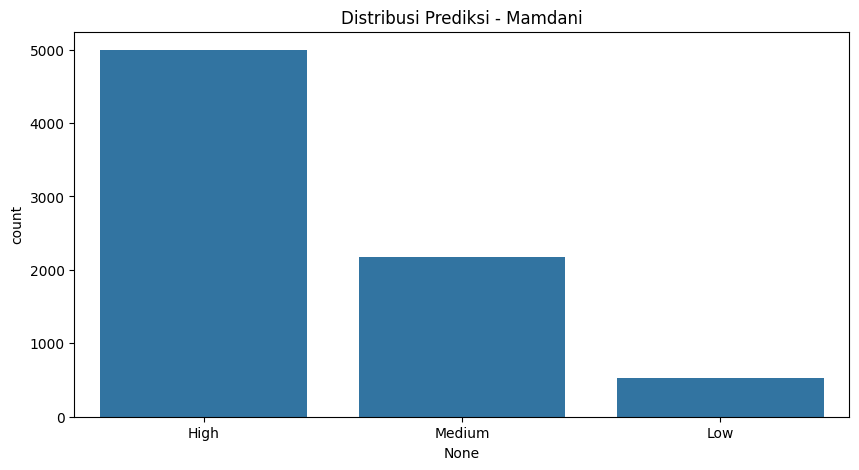

Evaluasi Model: Mamdani
Akurasi: 0.5900637274027832
Presisi: 0.7040223687452287
Recall: 0.5900637274027832
F1-Score: 0.6374913436702027


Evaluasi Model: Mamdani
Akurasi: 0.8720249707374171
Presisi: 0.8545104950205128
Recall: 0.8720249707374171
F1-Score: 0.8622981556640875




c:\Users\Shiro\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KeyError: "None of [Index(['Accuracy', 'Precision', 'Recall', 'F1'], dtype='object')] are in the [index]"

<Figure size 1200x600 with 0 Axes>

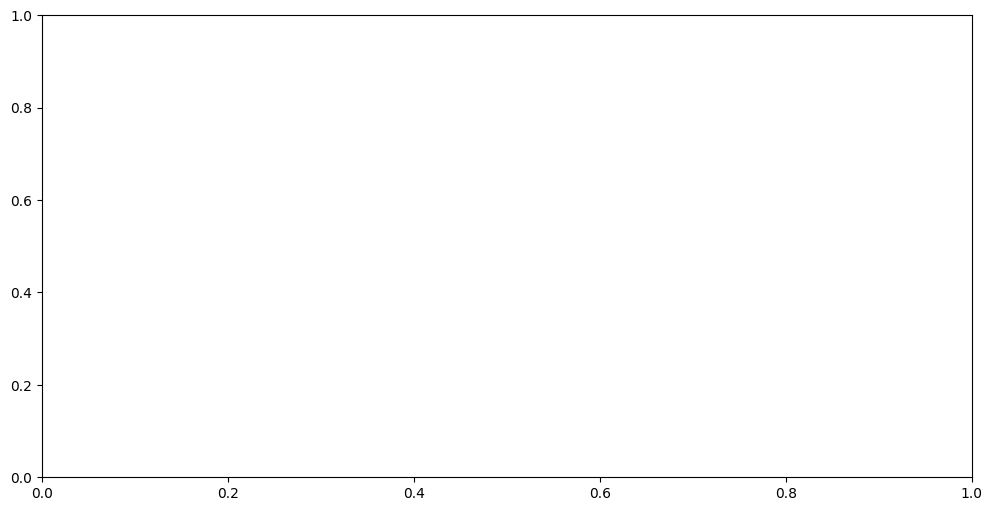

In [219]:
# Evaluasi model
def evaluate_model(y_true, y_pred, model_name):
    print(f"Evaluasi Model: Mamdani")
    print("Akurasi:", accuracy_score(y_true, y_pred))
    print("Presisi:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall:", recall_score(y_true, y_pred, average='weighted'))
    print("F1-Score:", f1_score(y_true, y_pred, average='weighted'))
    print("\n")

evaluate_model(y_test, y_pred_mamdani, "Fuzzy Mamdani")

# Visualisasi distribusi prediksi
plt.figure(figsize=(10, 5))
sb.countplot(x=y_pred_mamdani)
plt.title('Distribusi Prediksi - Mamdani')
plt.show()

mamdani_metrics = evaluate_model(y_test, y_pred_mamdani, "Fuzzy Mamdani")

# Encode categorical features (FeedbackScore)
le_fs = LabelEncoder()
X_train['FeedbackScore_encoded'] = le_fs.fit_transform(X_train['FeedbackScore'])
X_test['FeedbackScore_encoded'] = le_fs.transform(X_test['FeedbackScore'])

# Drop the original FeedbackScore column
X_train = X_train.drop('FeedbackScore', axis=1)
X_test = X_test.drop('FeedbackScore', axis=1)

# Now train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_encoded)

# Predict with Random Forest
y_pred_rf_encoded = rf_model.predict(X_test)
y_pred_rf = le.inverse_transform(y_pred_rf_encoded)

# Evaluate Random Forest
rf_metrics = evaluate_model(y_test, y_pred_rf, "Random Forest")

# ========== PERBANDINGAN MODEL ==========
# Buat dataframe untuk perbandingan metrik
comparison_df = pd.DataFrame([mamdani_metrics, rf_metrics])

# Visualisasi perbandingan metrik
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, comparison_df.iloc[0][metrics], width, label='Fuzzy Mamdani')
rects2 = ax.bar(x + width/2, comparison_df.iloc[1][metrics], width, label='Random Forest')

ax.set_ylabel('Score')
ax.set_title('Perbandingan Metrik Evaluasi')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Tambahkan nilai di atas bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

# Visualisasi distribusi prediksi
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Fuzzy Mamdani
sb.countplot(x=y_pred_mamdani, ax=axes[0])
axes[0].set_title('Distribusi Prediksi - Fuzzy Mamdani')

# Random Forest
sb.countplot(x=y_pred_rf, ax=axes[1])
axes[1].set_title('Distribusi Prediksi - Random Forest')

plt.tight_layout()
plt.show()

# Tampilkan dataframe perbandingan
print("\nPerbandingan Metrik Evaluasi:")
display(comparison_df)